In [183]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

In [184]:
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

data/train.csv
data/gender_submission.csv
data/.DS_Store
data/test.csv


In [185]:
train_data = pd.read_csv("data/train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [186]:
test_data = pd.read_csv("data/test.csv")
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [318]:
Y = torch.tensor(train_data["Survived"].values).type(torch.float32)
features = ["Pclass", "Sex", "SibSp", "Parch"]
X = torch.tensor(pd.get_dummies(train_data[features]).values).type(torch.float32)
Y = Y.view(X.shape[0], -1)
print(Y.shape)
print(X)

torch.Size([891, 1])
tensor([[3., 1., 0., 0., 1.],
        [1., 1., 0., 1., 0.],
        [3., 0., 0., 1., 0.],
        ...,
        [3., 1., 2., 1., 0.],
        [1., 0., 0., 0., 1.],
        [3., 0., 0., 0., 1.]])


In [319]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.1)

In [320]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 4 fully connected layer
        self.fc1 = nn.Linear(5, 32)
        self.fc2 = nn.Linear(32, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.dropout(x, p = 0.1)
        x = F.relu(x)
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return torch.sigmoid(x)
    
net = Net()
print(net)

Net(
  (fc1): Linear(in_features=5, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


In [321]:
criterion = nn.BCELoss()
opt = optim.Adam(net.parameters(), lr=0.001)

Epoch 1
Epoch 6
Epoch 11
Epoch 16
Epoch 21
Epoch 26
Epoch 31
Epoch 36
Epoch 41
Epoch 46
Epoch 51
Epoch 56
Epoch 61
Epoch 66
Epoch 71
Epoch 76
Epoch 81
Epoch 86
Epoch 91
Epoch 96
Epoch 101
Epoch 106
Epoch 111
Epoch 116


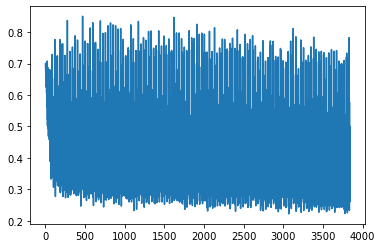

In [322]:
batch_size = 25
num_epochs = 120
batch_no = len(x_train) // batch_size
losses = []

for epoch in range(num_epochs):
    for i in range(batch_no):
        start = i * batch_size
        end = start + batch_size
        x_var = Variable(x_train[start:end])
        y_var = Variable(y_train[start:end])
        # Forward + Backward + Optimize
        opt.zero_grad()
        ypred_var = net(x_var)
        loss =criterion(ypred_var, y_var)
        loss.backward()
        opt.step()
        losses.append(loss.data.numpy())  
    if epoch % 5 == 0:
        print('Epoch {}'.format(epoch+1))
        
plt.plot(losses)

In [323]:
test_var = Variable(torch.FloatTensor(x_val), requires_grad=True)
with torch.no_grad():
    result = net(test_var)
labels = torch.gt(result, 0.5).type(torch.float32)
num_right = np.sum(labels.data.numpy() == y_val.data.numpy())
print('Accuracy {:.2f}'.format(num_right / len(y_val)))

Accuracy 0.78


In [287]:
# Applying model on the test data
X_test = torch.tensor(pd.get_dummies(test_data[features]).values).type(torch.float32)
X_test_var = Variable(torch.FloatTensor(X_test), requires_grad=True) 
with torch.no_grad():
    test_result = net(X_test_var)
test_labels = torch.gt(test_result, 0.5).type(torch.float32)
survived = np.int32(test_labels.data.numpy())
#print(survived)
import csv
test_passengers_id = test_data["PassengerId"].values

submission = [['PassengerId', 'Survived']]
for i in range(len(survived)):
    submission.append([test_passengers_id[i], survived[i][0]])
with open('submission.csv', 'w') as submissionFile:
    writer = csv.writer(submissionFile)
    writer.writerows(submission)
    
print('Writing Complete!')

Writing Complete!
